In [1]:
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
import time

import properties as prop
import random_initialization as rand_init
import matrixes as ma
import interblock_matrixes as i_ma
import utils as u
import reservoir as res

imp.reload(prop)
imp.reload(rand_init)
imp.reload(ma)
imp.reload(i_ma)
imp.reload(u)
imp.reload(res)

const = prop.Constants()

In [2]:
ns = 50000
x_min, x_max = -1.3, 1.3
y_min, y_max = -1.3, 1.3
nx , ny = 20, 15

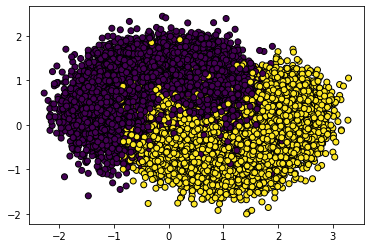

In [3]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.4)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()

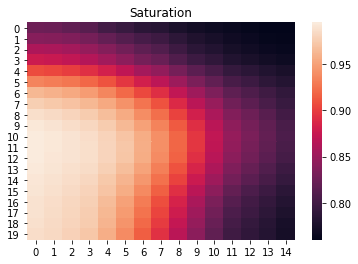

In [4]:
Satur_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=1, x_min=-1,
                                                 y_min=-1, y_max=1, n_x=nx, n_y=ny
                                                )
sns.heatmap(Satur_matrix)
plt.title("Saturation")
plt.show()

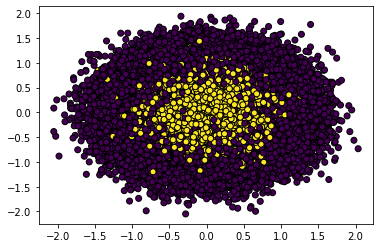

In [5]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()  

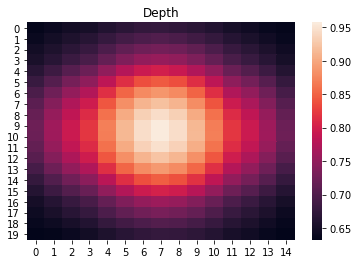

In [6]:
depth_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(depth_matrix)
plt.title("Depth")
plt.show()

In [7]:
assert np.isnan(depth_matrix).sum() == 0

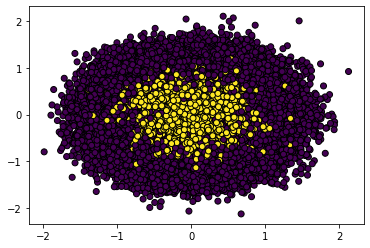

In [8]:
ds = rand_init.get_depth_scattered(n_samples=ns)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show()   

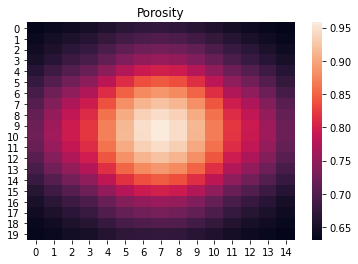

In [9]:
porosity_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max, x_min=x_min,
                                                 y_min=y_min, y_max=y_max, n_x=nx, n_y=ny
                                                )
sns.heatmap(porosity_matrix)
plt.title("Porosity")
plt.show()

In [10]:
assert np.isnan(porosity_matrix).sum() == 0

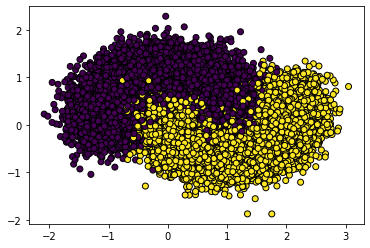

In [11]:
ds = rand_init.get_saturation_scattered(n_samples=ns, noise=0.3)
plt.scatter(ds[0][:, 0],ds[0][:, 1], c=ds[1], edgecolors='k')
plt.show() 

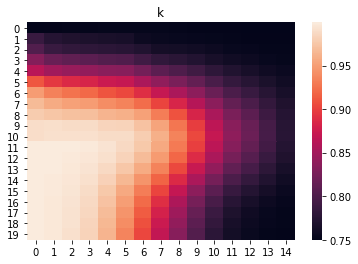

In [12]:
k_matrix = rand_init.get_grid_from_scattered(ds=ds, x_max=x_max-0.1, x_min=x_min+0.1,
                                             y_min=y_min+0.1, y_max=y_max-0.1, n_x=nx, n_y=ny
                                            )
sns.heatmap(k_matrix)
plt.title("k")
plt.show()

In [13]:
assert np.isnan(k_matrix).sum() == 0

Давления пусть будут одинаково распределены

In [14]:
dy = np.ones(ny) * const.dy()
dx = np.ones(nx) * const.dx()

p_vec = np.ones((nx*ny)).reshape((-1, 1)) * const.p_0()
S_o_vec = Satur_matrix.reshape((-1, 1))
S_w_vec = (np.ones(Satur_matrix.shape) - Satur_matrix).reshape((-1, 1))

Обозначем важные прмежуточные матрицы для 
$$\vec{p^{n+1}} = \vec{p^{n}} + \Delta t \big[B^{p, w}\big]^{-1}\big[ T^{upd}_{\tilde{k}} \vec{p} + \tilde{Q} + \frac{B_o}{B_w} q_o^{well} + q_w^{well}\big]$$

In [15]:
wells = {(2, 14): -1e-1,
         (10, 4): -1e-1
        }

In [16]:
env = res.Env(k_2d_matrix=k_matrix, poir_2d_matrix=porosity_matrix, depth_2d_matrix=depth_matrix,
                 satur_2d_matrix=Satur_matrix,
                 const=const, well_positions=wells
                 )

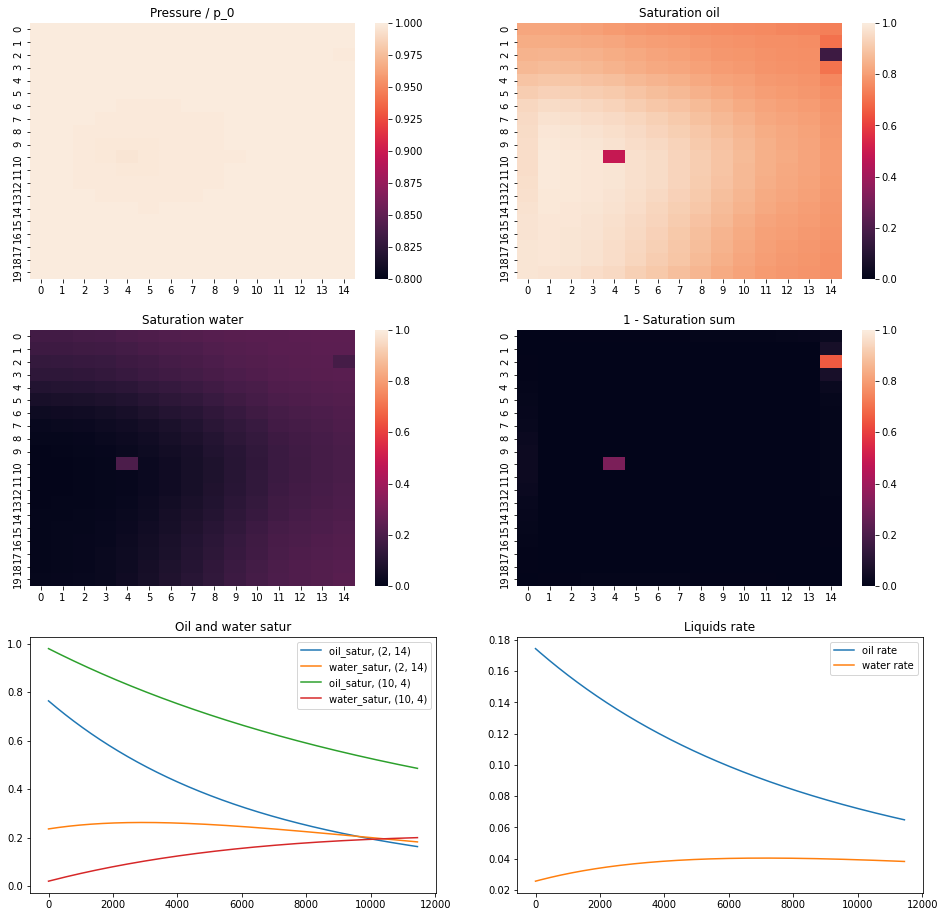

In [ ]:
n_it = int(1e6)
q_o_rate = []
q_w_rate = []

s_o_hist = {key: [] for key in wells}
s_w_hist = {key: [] for key in wells}

for i in range(n_it):
    env.step()
    
    s_o = env.s_o_as_2d()
    s_w = env.s_w_as_2d()
    
    q_w_rate.append(env.q_w_total())
    q_o_rate.append(env.q_o_total())
    
    for key in wells:
        s_o_hist[key].append(s_o[key[0], key[1]])
        s_w_hist[key].append(s_w[key[0], key[1]])
    
    if i % 50 == 0:
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
        
        g1 = sns.heatmap(env.p_as_2d() / const.p_0(), ax=ax[0][0], cbar=True, vmax=1, vmin=0.8)
        g1.set_title('Pressure / p_0')
        
        g2 = sns.heatmap(env.s_o_as_2d(), ax=ax[0][1], cbar=True, vmax=1, vmin=0)
        g2.set_title('Saturation oil')

        g3 = sns.heatmap(s_w, ax=ax[1][0], cbar=True, vmax=1, vmin=0)
        g3.set_title('Saturation water')
        
        g4 = sns.heatmap(np.ones((nx, ny)) - s_w - s_o, ax=ax[1][1], cbar=True, vmax=1, vmin=0)
        g4.set_title('1 - Saturation sum')
        
        # plot satur in every well
        for key in wells:
            ax[2][0].plot(s_o_hist[key], label=f'oil_satur, {key}')
            ax[2][0].plot(s_w_hist[key], label=f'water_satur, {key}')
        ax[2][0].set_title('Oil and water satur')
        ax[2][0].legend()
        
        ax[2][1].plot(q_o_rate, label='oil rate')
        ax[2][1].plot(q_w_rate, label='water rate')
        ax[2][1].set_title('Liquids rate')
        ax[2][1].legend()
        
        plt.show()
print()